# Initial Setup and Data Loading

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    accuracy_score, classification_report, confusion_matrix, roc_auc_score,
    average_precision_score, f1_score, precision_recall_curve,
    precision_score, recall_score
)
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import xgboost as xgb
from lightgbm import LGBMClassifier
import warnings
import lightgbm as lgb


Load the feature-engineered hourly dataset. Timestamp is put into datetime form and set as the index.

In [3]:
# Load the feature-engineered hourly dataset
file_name = 'banff_parking_engineered_HOURLY (1).csv'

try:
    df = pd.read_csv(file_name)
    print(f"--- File '{file_name}' loaded successfully --- (shape: {df.shape})")

    # Convert Timestamp to datetime and set as index
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    df = df.set_index('Timestamp').sort_index()

    print("--- Data Types ---")
    print(df.info())
    print("\n--- Sample Data ---")
    print(df.head())

except FileNotFoundError:
    print(f"ERROR: The file '{file_name}' was not found.")
    print("Please ensure the file is uploaded to your Colab environment.")
except Exception as e:
    print(f"An error occurred: {e}")

--- File 'banff_parking_engineered_HOURLY (1).csv' loaded successfully --- (shape: (82434, 17))
--- Data Types ---
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 82434 entries, 2025-05-01 01:00:39 to 2025-09-01 08:00:39
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unit                    82434 non-null  object 
 1   Occupancy               82434 non-null  int64  
 2   Max Temp (°C)           82434 non-null  float64
 3   Min Temp (°C)           82434 non-null  float64
 4   Total Precip (mm)       82434 non-null  float64
 5   Spd of Max Gust (km/h)  82434 non-null  float64
 6   Hour                    82434 non-null  int64  
 7   DayOfWeek               82434 non-null  int64  
 8   Month                   82434 non-null  int64  
 9   IsWeekend               82434 non-null  int64  
 10  Occupancy_1hr_Ago       82434 non-null  float64
 11  Occupancy_24hr_Ago      82434 non-null  float64

# **Preprocessing for Modeling**

In [4]:
import warnings
warnings.filterwarnings("ignore")

DATE_COL = 'timestamp' # Define DATE_COL globally here
TARGET_REG = 'Occupancy' # Define TARGET_REG for regression task
TARGET_CLS = 'Is_Full' # Define TARGET_CLS for classification task

def chrono_split(df_to_split, date_col=DATE_COL, train_frac=0.7, val_frac=0.2):
    # Ensure the date_col is present and sorted
    if date_col not in df_to_split.columns:
        raise ValueError(f"'{date_col}' not found as a column in the DataFrame.")

    df_to_split = df_to_split.sort_values(by=date_col).reset_index(drop=True)
    n = len(df_to_split)
    n_train = int(n * train_frac)
    n_val = int(n * val_frac)

    train = df_to_split.iloc[:n_train].copy()
    val = df_to_split.iloc[n_train:n_train + n_val].copy()
    test = df_to_split.iloc[n_train + n_val:].copy()

    return train, val, test

def add_time_features(df_in, date_col=DATE_COL):
    df = df_in.copy()
    df[date_col] = pd.to_datetime(df[date_col])
    df['hour'] = df[date_col].dt.hour
    df['dow'] = df[date_col].dt.weekday
    df['day_of_year'] = df[date_col].dt.dayofyear
    # cyclical encodings
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['dow_sin'] = np.sin(2 * np.pi * df['dow'] / 7)
    df['dow_cos'] = np.cos(2 * np.pi * df['dow'] / 7)
    df['is_weekend'] = df['dow'].isin([5,6]).astype(int)
    return df

def add_lag_features(df_in, cols, lags=[1,2,3,24,168]):
    df = df_in.copy()
    # df must be sorted by timestamp
    for col in cols:
        for lag in lags:
            df[f'{col}_lag_{lag}'] = df[col].shift(lag)
    return df

def add_rolling_features(df_in, cols, windows=[3,7,30]):
    df = df_in.copy()
    for col in cols:
        for w in windows:
            # shift(1) to avoid using current row in window (no leakage)
            df[f'{col}_roll_mean_{w}'] = df[col].rolling(window=w, min_periods=1).mean().shift(1)
            df[f'{col}_roll_std_{w}']  = df[col].rolling(window=w, min_periods=1).std().shift(1)
    return df

if 'df' in locals():
    print("--- Applying Feature Engineering ---")

    # Ensure 'Timestamp' is a column and renamed to DATE_COL
    if df.index.name == 'Timestamp':
        df = df.reset_index()
    if 'Timestamp' in df.columns and 'timestamp' == DATE_COL: # Check if 'Timestamp' exists and needs renaming
        df = df.rename(columns={'Timestamp': DATE_COL})

    # Choose numeric columns to create lags/rolling for.
    numeric_cols = [TARGET_REG] + [c for c in df.columns if df[c].dtype.kind in 'fi' and c not in [TARGET_REG, TARGET_CLS, DATE_COL]]

    # Sort df by DATE_COL before applying time-series features
    df = df.sort_values(by=DATE_COL).reset_index(drop=True)

    df = add_time_features(df, date_col=DATE_COL)
    df = add_lag_features(df, cols=numeric_cols, lags=[1,2,3,24,168])
    df = add_rolling_features(df, cols=numeric_cols, windows=[3,7,30])

    print(f"Shape after feature engineering: {df.shape}")

    # --- Apply Chronological Split ---
    train_df, val_df, test_df = chrono_split(df, date_col=DATE_COL,
                                             train_frac=0.7, val_frac=0.2)

    print(f"\n--- Data Split (using chrono_split) ---")
    print(f"Train set shape: {train_df.shape}")
    print(f"Validation set shape: {val_df.shape}")
    print(f"Test set shape: {test_df.shape}")

    # drop initial rows with NaNs produced by lags in each split (warmup)
    def drop_warmup(df_split):
        initial_rows = df_split.shape[0]
        df_cleaned = df_split.dropna().reset_index(drop=True)
        print(f"{initial_rows - df_cleaned.shape[0]} rows with NaNs dropped from a split.")
        return df_cleaned

    print("\n--- Dropping NaNs from splits (warm-up period) ---")
    train_df = drop_warmup(train_df)
    val_df   = drop_warmup(val_df)
    test_df  = drop_warmup(test_df)

    print(f"After warmup drop: Train {len(train_df)} | Val {len(val_df)} | Test {len(test_df)}")

else:
    print("DataFrame 'df' not found. Please load the data in the previous cell.")

--- Applying Feature Engineering ---
Shape after feature engineering: (82434, 179)

--- Data Split (using chrono_split) ---
Train set shape: (57703, 179)
Validation set shape: (16486, 179)
Test set shape: (8245, 179)

--- Dropping NaNs from splits (warm-up period) ---
168 rows with NaNs dropped from a split.
0 rows with NaNs dropped from a split.
0 rows with NaNs dropped from a split.
After warmup drop: Train 57535 | Val 16486 | Test 8245


In [5]:
if 'train_df' in locals() and 'val_df' in locals() and 'test_df' in locals():
    print("--- Further Preprocessing on Split Data ---")

    # --- 1. One-Hot Encode Categorical Features for each split ---
    # 'Unit' is the only categorical feature that needs encoding
    train_df_processed = pd.get_dummies(train_df, columns=['Unit'], drop_first=True)
    val_df_processed = pd.get_dummies(val_df, columns=['Unit'], drop_first=True)
    test_df_processed = pd.get_dummies(test_df, columns=['Unit'], drop_first=True)

    print(f"Shape after one-hot encoding: Train {train_df_processed.shape} | Val {val_df_processed.shape} | Test {test_df_processed.shape}")

    # --- 2. Define Features (X) and Targets (y) ---

    # Features are all columns EXCEPT the two targets and Percent_Occupancy (which is a data leak for Is_Full)
    excluded_cols = [TARGET_REG, TARGET_CLS, 'Percent_Occupancy', DATE_COL] # Exclude DATE_COL from features
    # Ensure FEATURES list is consistent across splits
    # Take features from the training set, which should have all possible encoded unit columns
    FEATURES = [col for col in train_df_processed.columns if col not in excluded_cols]

    X_train, y_reg_train, y_cls_train = train_df_processed[FEATURES], train_df_processed[TARGET_REG], train_df_processed[TARGET_CLS]
    X_val, y_reg_val, y_cls_val = val_df_processed[FEATURES], val_df_processed[TARGET_REG], val_df_processed[TARGET_CLS]
    X_test, y_reg_test, y_cls_test = test_df_processed[FEATURES], test_df_processed[TARGET_REG], test_df_processed[TARGET_CLS]

    # --- Handle Class Imbalance (for Classification Task) ---
    # Calculate this based on the training set after all preprocessing
    class_counts = y_cls_train.value_counts()
    scale_pos_weight = class_counts[0] / class_counts[1]
    print(f"\nClass balance check (train set): '{TARGET_CLS}' = 1 occurs {class_counts[1] / class_counts.sum() * 100:.2f}% of the time.")
    print(f"Calculated 'scale_pos_weight': {scale_pos_weight:.2f}")

    print(f"\n--- Data Shapes after One-Hot Encoding & Feature Selection ---")
    print(f"Training set shape: {X_train.shape}")
    print(f"Validation set shape: {X_val.shape}")
    print(f"Test set shape:     {X_test.shape}")

    # --- 3. Feature Scaling ---
    # Scale features after splitting to prevent data leakage from the test/validation set
    scaler = StandardScaler()
    X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=FEATURES, index=X_train.index)
    X_val_scaled = pd.DataFrame(scaler.transform(X_val), columns=FEATURES, index=X_val.index)
    X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=FEATURES, index=X_test.index)

    print("\n--- Features scaled successfully ---")
else:
    print("Split DataFrames (train_df, val_df, test_df) not found. Please run the feature engineering cell first.")

--- Further Preprocessing on Split Data ---
Shape after one-hot encoding: Train (57535, 195) | Val (16486, 195) | Test (8245, 195)

Class balance check (train set): 'Is_Full' = 1 occurs 0.93% of the time.
Calculated 'scale_pos_weight': 106.74

--- Data Shapes after One-Hot Encoding & Feature Selection ---
Training set shape: (57535, 191)
Validation set shape: (16486, 191)
Test set shape:     (8245, 191)

--- Features scaled successfully ---


# Task 1: Regression - Predicting Hourly Occupancy

XGBoost Regressor with Pipeline


In [6]:

if 'X_train' in locals():
    print("\n--- Hyperparameter Tuning for XGBoost Regressor (with Pipeline) ---")
   # 1. Initialize the XGBoost Regressor
    # We use 'reg:squarederror' for regression.
    model_xgb_reg = xgb.XGBRegressor(objective='reg:squarederror',
                                     n_estimators=100,
                                     random_state=42,
                                     n_jobs=-1)

    # 2. Train the model
    model_xgb_reg.fit(X_train_scaled, y_reg_train)
    print("Base XGBoost Regressor model trained.")

    # 3. Evaluate the base model on the test set
    print("\n--- Evaluating Base XGBoost Regressor on Test Set ---")
    y_pred_reg = model_xgb_reg.predict(X_test_scaled)

    mae = mean_absolute_error(y_reg_test, y_pred_reg)
    rmse = np.sqrt(mean_squared_error(y_reg_test, y_pred_reg))
    r2 = r2_score(y_reg_test, y_pred_reg)

    print(f"Base Model Test Set Metrics:")
    print(f"  R-squared (R2): {r2:.3f}")
    print(f"  Mean Absolute Error (MAE): {mae:.3f} vehicles")
    print(f"  Root Mean Squared Error (RMSE): {rmse:.3f} vehicles")


else:
    print("Training data not found. Please run the preprocessing cell.")


--- Hyperparameter Tuning for XGBoost Regressor (with Pipeline) ---
Base XGBoost Regressor model trained.

--- Evaluating Base XGBoost Regressor on Test Set ---
Base Model Test Set Metrics:
  R-squared (R2): 0.929
  Mean Absolute Error (MAE): 0.934 vehicles
  Root Mean Squared Error (RMSE): 1.876 vehicles



--- Hyperparameter Tuning for XGBoost Regressor ---
(This may take a few minutes)...

Fitting 5 folds for each of 16 candidates, totalling 80 fits

Best parameters found: {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200}
Best cross-validation (negative) MAE: -0.912

--- Evaluating Tuned XGBoost Regressor on Test Set ---
Tuned Model Test Set Metrics:
  R-squared (R2): 0.930
  Mean Absolute Error (MAE): 0.917 vehicles
  Root Mean Squared Error (RMSE): 1.865 vehicles


<Figure size 1500x700 with 0 Axes>

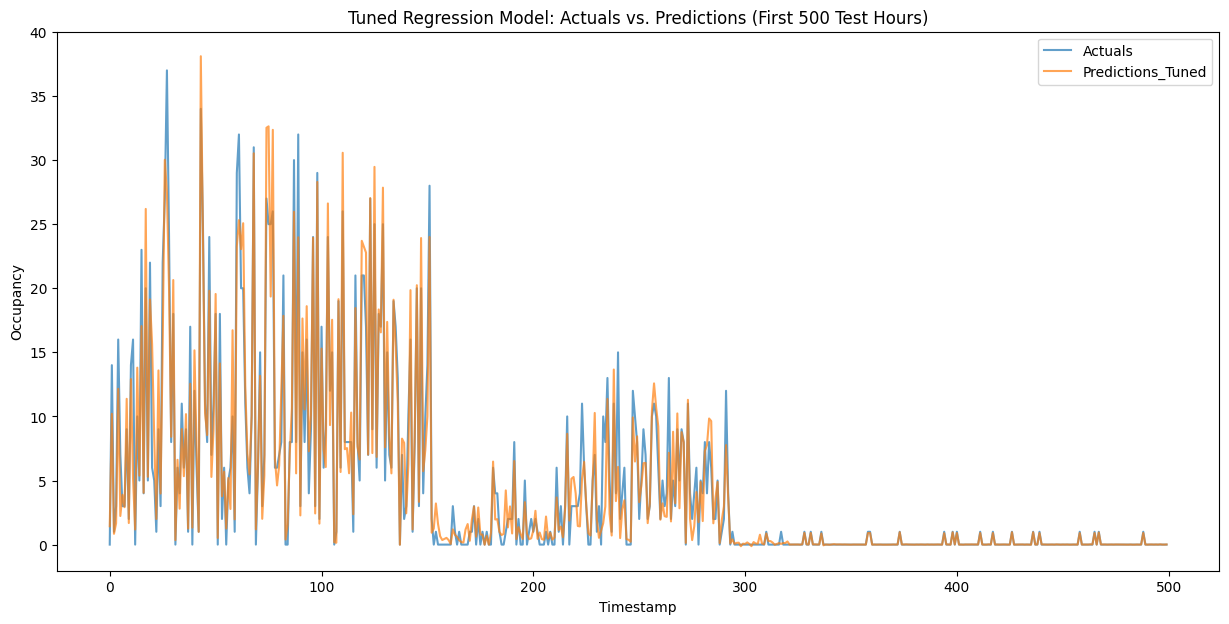

In [7]:
if 'X_train_scaled' in locals():
    # --- 4. Hyperparameter Tuning (GridSearchCV) ---
    print("\n--- Hyperparameter Tuning for XGBoost Regressor ---")
    print("(This may take a few minutes)...\n")

    # Reduced grid for faster optimization. Expand this for a more thorough search.
    param_grid_xgb_reg = {
        'n_estimators': [100, 200],
        'max_depth': [3, 5],
        'learning_rate': [0.05, 0.1],
        'colsample_bytree': [0.7, 1.0]
    }

    # Use the same TimeSeriesSplit for cross-validation within the grid search
    tscv_grid = TimeSeriesSplit(n_splits=5)

    grid_search_reg = GridSearchCV(estimator=xgb.XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1),
                                 param_grid=param_grid_xgb_reg,
                                 cv=tscv_grid,
                                 scoring='neg_mean_absolute_error', # Optimize for MAE
                                 n_jobs=-1,
                                 verbose=1)

    # Fit the grid search on the training data
    grid_search_reg.fit(X_train_scaled, y_reg_train)

    print(f"\nBest parameters found: {grid_search_reg.best_params_}")
    print(f"Best cross-validation (negative) MAE: {grid_search_reg.best_score_:.3f}")

    # 5. Evaluate the Tuned Model
    best_xgb_reg = grid_search_reg.best_estimator_
    print("\n--- Evaluating Tuned XGBoost Regressor on Test Set ---")
    y_pred_reg_tuned = best_xgb_reg.predict(X_test_scaled)

    mae_tuned = mean_absolute_error(y_reg_test, y_pred_reg_tuned)
    rmse_tuned = np.sqrt(mean_squared_error(y_reg_test, y_pred_reg_tuned))
    r2_tuned = r2_score(y_reg_test, y_pred_reg_tuned)

    print(f"Tuned Model Test Set Metrics:")
    print(f"  R-squared (R2): {r2_tuned:.3f}")
    print(f"  Mean Absolute Error (MAE): {mae_tuned:.3f} vehicles")
    print(f"  Root Mean Squared Error (RMSE): {rmse_tuned:.3f} vehicles")

    # 6. Plot Predictions vs. Actuals
    results_df_reg = pd.DataFrame({
        'Actuals': y_reg_test,
        'Predictions_Tuned': y_pred_reg_tuned
    }, index=y_reg_test.index)

    plt.figure(figsize=(15, 7))
    # Plot a subset for clarity (e.g., first 500 hours of the test set)
    results_df_reg.head(500).plot(alpha=0.7, figsize=(15, 7))
    plt.title('Tuned Regression Model: Actuals vs. Predictions (First 500 Test Hours)')
    plt.ylabel('Occupancy')
    plt.xlabel('Timestamp')
    plt.legend()
    plt.show()
else:
    print("Data not found. Please run the preprocessing cell.")

LightGBM Regressor


--- Hyperparameter Tuning for LightGBM Regressor ---
(This may take a few minutes)...

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.133272 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18765
[LightGBM] [Info] Number of data points in the train set: 57535, number of used features: 189
[LightGBM] [Info] Start training from score 2.954167
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

<Figure size 1500x700 with 0 Axes>

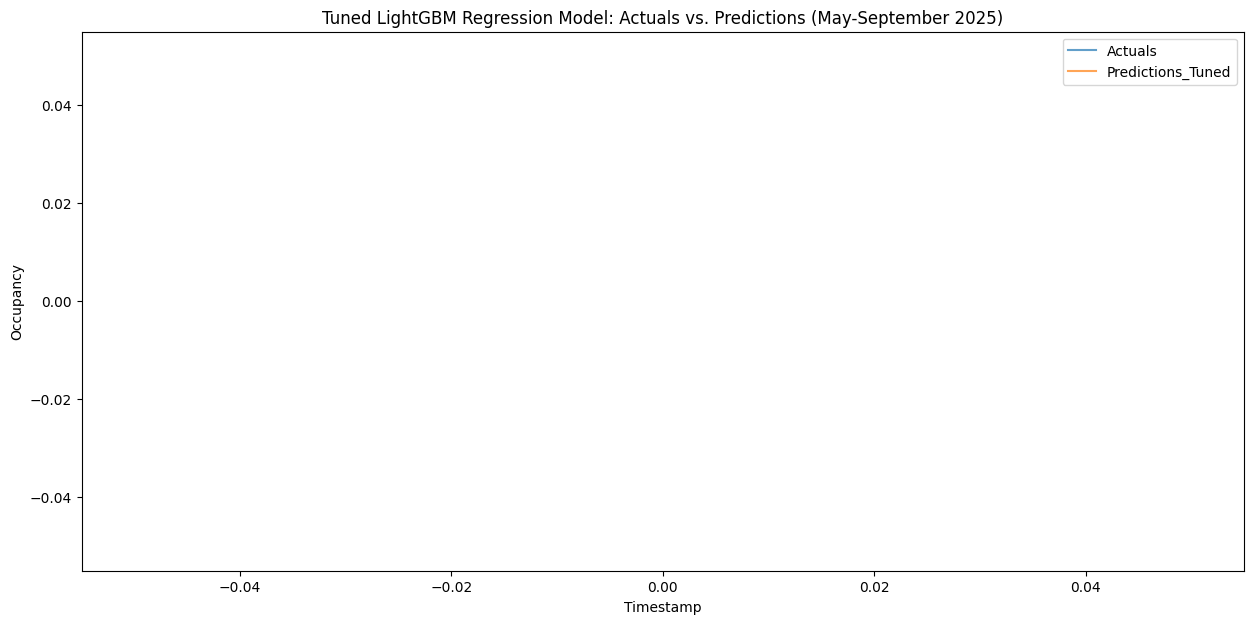

In [9]:
if 'X_train_scaled' in locals():
    print("\n--- Hyperparameter Tuning for LightGBM Regressor ---")
    print("(This may take a few minutes)...\n")

    # 1. Define a parameter grid for tuning
    param_grid_lgbm_reg = {
        'n_estimators': [100, 200],
        'max_depth': [3, 5],
        'learning_rate': [0.05, 0.1],
        'subsample': [0.7, 1.0], # Subsample ratio of the training instance.
        'colsample_bytree': [0.7, 1.0] # Subsample ratio of columns when constructing each tree.
    }

    # 2. Use the same TimeSeriesSplit for cross-validation within the grid search
    tscv_grid = TimeSeriesSplit(n_splits=5)

    # 3. Create a GridSearchCV object
    grid_search_lgbm_reg = GridSearchCV(estimator=lgb.LGBMRegressor(random_state=42, n_jobs=-1, objective='regression'),
                                 param_grid=param_grid_lgbm_reg,
                                 cv=tscv_grid,
                                 scoring='neg_mean_absolute_error', # Optimize for MAE
                                 n_jobs=-1,
                                 verbose=1)

    # 4. Fit the grid search on the training data
    grid_search_lgbm_reg.fit(X_train_scaled, y_reg_train)

    # 5. Print the best parameters and score
    print(f"\nBest parameters found: {grid_search_lgbm_reg.best_params_}")
    print(f"Best cross-validation (negative) MAE: {grid_search_lgbm_reg.best_score_:.3f}")

    # 6. Retrieve the best estimator
    best_lgbm_reg = grid_search_lgbm_reg.best_estimator_

    # 7. Make predictions with the tuned model
    print("\n--- Evaluating Tuned LightGBM Regressor on Test Set ---")
    y_pred_lgbm_tuned = best_lgbm_reg.predict(X_test_scaled)

    # 8. Calculate and print evaluation metrics
    mae_lgbm_tuned = mean_absolute_error(y_reg_test, y_pred_lgbm_tuned)
    rmse_lgbm_tuned = np.sqrt(mean_squared_error(y_reg_test, y_pred_lgbm_tuned))
    r2_lgbm_tuned = r2_score(y_reg_test, y_pred_lgbm_tuned)

    print(f"Tuned LightGBM Model Test Set Metrics:")
    print(f"  R-squared (R2): {r2_lgbm_tuned:.3f}")
    print(f"  Mean Absolute Error (MAE): {mae_lgbm_tuned:.3f} vehicles")
    print(f"  Root Mean Squared Error (RMSE): {rmse_lgbm_tuned:.3f} vehicles")

    # 9. Plot Predictions vs. Actuals
    results_df_lgbm_reg = pd.DataFrame({
        'Actuals': y_reg_test,
        'Predictions_Tuned': y_pred_lgbm_tuned
    }, index=y_reg_test.index)

    plt.figure(figsize=(15, 7))
    results_df_lgbm_reg.loc['2025-05-01':'2025-09-30'].plot(alpha=0.7, figsize=(15, 7))
    plt.title('Tuned LightGBM Regression Model: Actuals vs. Predictions (May-September 2025)')
    plt.ylabel('Occupancy')
    plt.xlabel('Timestamp')
    plt.legend()
    plt.show()

else:
    print("Data not found. Please run the preprocessing cell.")

# **Task 2: Classification - Predicting Near-Capactiy (>90% Full)**

Ligth GBM Classification model

--- Task 2: CLASSIFICATION Model Training (LightGBM) ---
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 534, number of negative: 57001
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.050582 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18765
[LightGBM] [Info] Number of data points in the train set: 57535, number of used features: 189
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.009281 -> initscore=-4.670428
[LightGBM] [Info] Start training from score -4.670428

Base LightGBM Classifier model trained.

--- Evaluating Base LightGBM Classifier on Test Set ---
Accuracy: 0.984
ROC-AUC Score: 0.934

--- Confusion Matrix ---


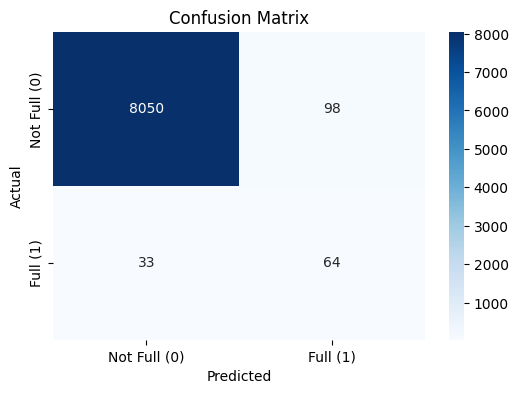


--- Classification Report ---
              precision    recall  f1-score   support

Not Full (0)       1.00      0.99      0.99      8148
    Full (1)       0.40      0.66      0.49        97

    accuracy                           0.98      8245
   macro avg       0.70      0.82      0.74      8245
weighted avg       0.99      0.98      0.99      8245



In [10]:
if 'X_train_scaled' in locals():
    print("--- Task 2: CLASSIFICATION Model Training (LightGBM) ---")



    # 2. Initialize the LightGBM Classifier
    model_lgbm_cls = lgb.LGBMClassifier(objective='binary', # For binary classification
                                        scale_pos_weight=scale_pos_weight, # Handle imbalance
                                        n_estimators=100,
                                        random_state=42,
                                        n_jobs=-1)

    # 3. Train the model
    model_lgbm_cls.fit(X_train_scaled, y_cls_train)
    print("\nBase LightGBM Classifier model trained.")

    # 4. Evaluate the base model on the test set
    print("\n--- Evaluating Base LightGBM Classifier on Test Set ---")
    y_pred_cls = model_lgbm_cls.predict(X_test_scaled)
    y_proba_cls = model_lgbm_cls.predict_proba(X_test_scaled)[:, 1] # Get probabilities for class 1

    print(f"Accuracy: {accuracy_score(y_cls_test, y_pred_cls):.3f}")
    print(f"ROC-AUC Score: {roc_auc_score(y_cls_test, y_proba_cls):.3f}")

    print("\n--- Confusion Matrix ---")
    cm = confusion_matrix(y_cls_test, y_pred_cls)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Not Full (0)', 'Full (1)'],
                yticklabels=['Not Full (0)', 'Full (1)'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()

    print("\n--- Classification Report ---")
    print(classification_report(y_cls_test, y_pred_cls, target_names=['Not Full (0)', 'Full (1)']))

else:
    print("Training data not found. Please run the preprocessing cell.")